In [3]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import logging
import matplotlib.pyplot as plt
import warnings
from models.model import EvRangeModel
warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Config:
    """
    Configuration settings for training the ev_range model,
    including model hyperparameters, training parameters, and dataset split ratios.
    """
    HIDDEN_DIM = 128
    NUM_LAYERS = 3
    DROPOUT = 0.2
    SEQUENCE_LENGTH = 50

    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    EPOCHS = 200
    PATIENCE = 20

    TEST_SIZE = 0.2
    VAL_SIZE = 0.1

class EVRangeProcessor:
    """
    Handles preprocessing of EV telemetry data into LSTM-ready sequences.
    """

    def __init__(self, config):
        self.config = config
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def preprocess_data(self, file_path):
        logger.info("Preprocessing data...")

        # Load data
        df = pd.read_csv(file_path)
        df.columns = [c.strip().lower() for c in df.columns]  # normalize header names

        # --- Identify Columns ---
        target_col = 'remaining_range_km'
        time_col = [c for c in df.columns if 'timestamp' in c][0]

        # Convert timestamp → datetime + sort
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.sort_values(time_col).reset_index(drop=True)

        # Extract target
        y = df[target_col].values.reshape(-1, 1)

        # Drop non-numeric or non-useful columns
        drop_cols = [
            time_col,          # not a model input
            target_col,        # kept separately
            'bms_version',     # categorical string
            'fault_code',      # often not numeric (and very sparse)
            'balancing_active' # boolean category 
        ]
        df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

        df = df.select_dtypes(include=[np.number])

        # Scale features + target separately
        X_scaled = self.scaler_X.fit_transform(df)
        y_scaled = self.scaler_y.fit_transform(y)

        # Create sequences for LSTM
        X_seq, y_seq = self.create_sequences(X_scaled, y_scaled)

        input_dim = X_seq.shape[2]
        logger.info(f"Preprocessed: {len(X_seq)} sequences | {input_dim} features")

        return X_seq, y_seq, input_dim


    def create_sequences(self, X, y):
        seq_len = self.config.SEQUENCE_LENGTH
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_len):
            X_seq.append(X[i:i + seq_len])
            y_seq.append(y[i + seq_len])
        return np.array(X_seq), np.array(y_seq).flatten()

    def inverse_transform_target(self, y_scaled):
        return self.scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
        
class EvRangeTrainer :
    def __init__(self,config=Config()):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")
    
    def create_data_loaders(self, X_seq, y_seq):
        X_temp, X_test, y_temp, y_test = train_test_split(X_seq, y_seq, test_size=self.config.TEST_SIZE, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=self.config.VAL_SIZE/(1-self.config.TEST_SIZE), random_state=42)

        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.float32)),
                                    batch_size=self.config.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                                torch.tensor(y_val, dtype=torch.float32)),
                                batch_size=self.config.BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                                torch.tensor(y_test, dtype=torch.float32)),
                                    batch_size=self.config.BATCH_SIZE, shuffle=False)
        logger.info(f"Training samples: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
        return train_loader, val_loader, test_loader
    
    def train_epoch(self, model, loader, criterion, optimizer):
        model.train()
        total_loss = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch).squeeze(), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)
    
    def validate_epoch(self, model, loader, criterion):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                loss = criterion(model(X_batch).squeeze(), y_batch)
                total_loss += loss.item()
        return total_loss / len(loader)
    
    def train_model(self,data_file, model_path="models/feddback_model.pth"):
        processor = EVRangeProcessor(self.config)
        X_seq, y_seq, input_dim = processor.preprocess_data(data_file)
        train_loader, val_loader, test_loader = self.create_data_loaders(X_seq, y_seq)
        
        model = EvRangeModel(input_dim=input_dim,
                                    hidden_dim=self.config.HIDDEN_DIM,
                                    num_layers=self.config.NUM_LAYERS,
                                    dropout=self.config.DROPOUT).to(self.device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.config.LEARNING_RATE)
        early_stopping = EarlyStopping(patience=self.config.PATIENCE)
        train_losses = []
        val_losses = []
        for epoch in range(self.config.EPOCHS):
            train_loss = self.train_epoch(model, train_loader, criterion, optimizer)
            val_loss = self.validate_epoch(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            logger.info(f"Epoch {epoch + 1}/{self.config.EPOCHS} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")
            if early_stopping(val_loss):
                logger.info("Early stopping triggered.")
                break
        torch.save(model.state_dict(), model_path)
        logger.info(f"Model saved to {model_path}")
        self.plot_training_curves(train_losses, val_losses)
        return model, processor
    
    @staticmethod
    def plot_training_curves(train_losses, val_losses):
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.title('Training Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        # plt.savefig('training_curves.png', dpi=300)
        plt.show()




2025-11-07 15:38:37,203 - INFO - Using device: cpu
2025-11-07 15:38:37,204 - INFO - Preprocessing data...
2025-11-07 15:38:37,242 - INFO - Preprocessed: 950 sequences | 27 features
2025-11-07 15:38:37,257 - INFO - Training samples: 665, Validation: 95, Test: 190
2025-11-07 15:38:38,630 - INFO - Epoch 1/200 - Train Loss: 0.2249 - Validation Loss: 0.0715
2025-11-07 15:38:39,903 - INFO - Epoch 2/200 - Train Loss: 0.0771 - Validation Loss: 0.0948
2025-11-07 15:38:41,226 - INFO - Epoch 3/200 - Train Loss: 0.0848 - Validation Loss: 0.0191
2025-11-07 15:38:42,619 - INFO - Epoch 4/200 - Train Loss: 0.0956 - Validation Loss: 0.0426
2025-11-07 15:38:43,658 - INFO - Epoch 5/200 - Train Loss: 0.0632 - Validation Loss: 0.0400
2025-11-07 15:38:44,444 - INFO - Epoch 6/200 - Train Loss: 0.0607 - Validation Loss: 0.0244
2025-11-07 15:38:45,190 - INFO - Epoch 7/200 - Train Loss: 0.0877 - Validation Loss: 0.0114
2025-11-07 15:38:45,957 - INFO - Epoch 8/200 - Train Loss: 0.0487 - Validation Loss: 0.0477
2

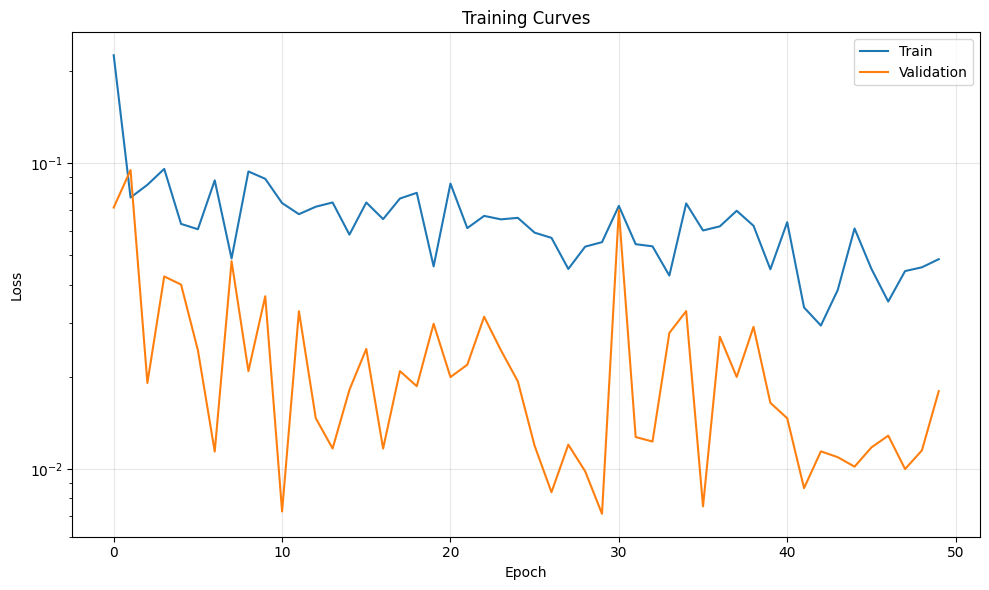

2025-11-07 15:39:17,480 - INFO - Training completed successfully!


In [9]:
if __name__ == "__main__":
    config = Config()
    trainer = EvRangeTrainer(config)
    data_file = "./mock_ev_bms_data.csv"   
    model, processor = trainer.train_model(data_file)
    logger.info("Training completed successfully!")

In [5]:
# save_scalers.py
import joblib
# from model_definitions import EVRangeProcessor, Config

if __name__ == "__main__":
    config = Config()
    processor = EVRangeProcessor(config)

    # Path to the same training data you used originally
    data_file = "./data/mock_ev_bms_data.csv"

    # Run preprocessing to rebuild scalers
    X_seq, y_seq, input_dim = processor.preprocess_data(data_file)

    # Save scalers
    joblib.dump(processor.scaler_X, "models/scaler_X.pkl")
    joblib.dump(processor.scaler_y, "models/scaler_y.pkl")

    print("✅ Scalers saved successfully.")


2025-11-07 15:46:40,383 - INFO - Preprocessing data...
2025-11-07 15:46:40,428 - INFO - Preprocessed: 950 sequences | 27 features


✅ Scalers saved successfully.


In [ ]:
import pandas as pd
import numpy as np
import torch
from models.model import EvRangeModel
from joblib import load

# Load model and scalers
model = EvRangeModel(input_dim=27)
model.load_state_dict(torch.load("models/feddback_model.pth", map_location="cpu"))
model.eval()

scaler_X = load("models/scaler_X.pkl")
scaler_y = load("models/scaler_y.pkl")

# Load your CSV (with multiple rows)
df = pd.read_csv(".data/mock_ev_bms_data.csv")

# Drop columns same as preprocessing
drop_cols = ['timestamp', 'remaining_range_km', 'bms_version', 'fault_code', 'balancing_active']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
df = df.select_dtypes(include=[np.number])

# Take last 50 rows to make one sequence
X_seq = df.tail(50).values
X_seq_scaled = scaler_X.transform(X_seq)

# Convert to tensor
sample_input = torch.tensor(X_seq_scaled, dtype=torch.float32).unsqueeze(0)  # (1, 50, 28)

# Predict
with torch.no_grad():
    y_pred_scaled = model(sample_input).squeeze().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

print("Predicted Remaining Range (km):", y_pred[0])


RuntimeError: Error(s) in loading state_dict for EvRangeModel:
	size mismatch for input_norm.weight: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for input_norm.bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for input_norm.running_mean: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for input_norm.running_var: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 27]) from checkpoint, the shape in current model is torch.Size([512, 28]).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_ev_bms_mock_data(num_minutes=500, start_soc=1.0, soh=0.96, seed=42):
    np.random.seed(seed)

    timestamps = [datetime(2025, 11, 1, 0, 0, 0) + timedelta(minutes=i) for i in range(num_minutes)]
    soc = np.linspace(start_soc, 0.1, num_minutes) + np.random.normal(0, 0.002, num_minutes)
    soc = np.clip(soc, 0.05, 1.0)

    # Pack voltage: roughly proportional to SOC but with current and temp influence
    nominal_voltage = 410
    pack_voltage = nominal_voltage * (0.9 + 0.1 * soc) + np.random.normal(0, 2, num_minutes)

    # Current: random variation, positive when discharging
    pack_current = np.random.normal(20, 5, num_minutes)

    # Temperature: rises slightly over time
    ambient_temp = np.random.normal(25, 0.5, num_minutes)
    cell_temp_avg = ambient_temp + np.linspace(0, 5, num_minutes) + np.random.normal(0, 0.2, num_minutes)
    cell_temp_min = cell_temp_avg - np.random.uniform(0.3, 0.8, num_minutes)
    cell_temp_max = cell_temp_avg + np.random.uniform(0.3, 0.8, num_minutes)

    # Individual cell voltages (12 cells)
    base_cell_voltage = pack_voltage / 12
    cell_voltages = [
        base_cell_voltage + np.random.normal(0, 0.01, num_minutes)
        for _ in range(12)
    ]

    # Health, resistance, etc.
    soh_series = np.full(num_minutes, soh)
    insulation_resistance = np.random.uniform(90, 120, num_minutes)
    balancing_active = np.random.choice([True, False], num_minutes, p=[0.1, 0.9])
    cycle_count = np.full(num_minutes, 420 + np.random.randint(0, 5))
    fault_code = np.zeros(num_minutes)

    # Remaining range (km) — roughly proportional to SOC and voltage
    remaining_range = 350 * soc * soh + np.random.normal(0, 3, num_minutes)
    remaining_range = np.clip(remaining_range, 0, None)

    # Construct DataFrame
    df = pd.DataFrame({
        "timestamp": timestamps,
        "pack_voltage_v": pack_voltage,
        "pack_current_a": pack_current,
        "state_of_charge": soc,
        "state_of_health": soh_series,
        "cell_volt_min_v": np.min(cell_voltages, axis=0),
        "cell_volt_max_v": np.max(cell_voltages, axis=0),
        "cell_volt_avg_v": np.mean(cell_voltages, axis=0),
        "cell_temp_min_c": cell_temp_min,
        "cell_temp_max_c": cell_temp_max,
        "cell_temp_avg_c": cell_temp_avg,
        "ambient_temp_c": ambient_temp,
        "charging_power_kw": np.zeros(num_minutes),
        "peak_power_kw": np.random.uniform(70, 100, num_minutes),
        "remaining_range_km": remaining_range,
        "balancing_active": balancing_active,
        "insulation_resistance_mohm": insulation_resistance,
        "fault_code": fault_code,
        "cycle_count": cycle_count,
        "bms_version": ["v3.2.1"] * num_minutes,
    })

    # Add individual cell voltages
    for i in range(12):
        df[f"cell_v_{i+1}_v"] = cell_voltages[i]

    return df


if __name__ == "__main__":
    df = generate_ev_bms_mock_data(num_minutes=1000)
    df.to_csv("mock_ev_bms_data.csv", index=False)
    print("✅ Mock EV BMS data generated and saved as 'mock_ev_bms_data.csv'")
    print(df.head(5))


✅ Mock EV BMS data generated and saved as 'mock_ev_bms_data.csv'
            timestamp  pack_voltage_v  pack_current_a  state_of_charge  \
0 2025-11-01 00:00:00      412.798711       16.624109         1.000000   
1 2025-11-01 00:01:00      411.800993       19.277407         0.998823   
2 2025-11-01 00:02:00      410.098497       16.037900         0.999494   
3 2025-11-01 00:03:00      408.706126       18.460192         1.000000   
4 2025-11-01 00:04:00      411.229498       10.531927         0.995928   

   state_of_health  cell_volt_min_v  cell_volt_max_v  cell_volt_avg_v  \
0             0.96        34.376348        34.422892        34.399037   
1             0.96        34.299539        34.323822        34.314289   
2             0.96        34.165010        34.189626        34.177421   
3             0.96        34.046594        34.073498        34.059725   
4             0.96        34.251169        34.290688        34.267980   

   cell_temp_min_c  cell_temp_max_c  ...  cell_v_3_